*Adapted from the keras example https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py*


This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/X_deep_learning/)

Given the computational load, an efficient alternative is to use the UGA's jupyterhub service https://jupyterhub.u-ga.fr/ .
In this case, to install tensorflow 2.X, just type

    !pip install --user --upgrade tensorflow

in a code cell, then restart the notebook (or just restart the kernel)

# Perform classification on MNIST dataset using convolutional neural networks (CNN)

The objective  of this notebook is to code/train/test some convolutional neural networks (CNN) with the [TensorFlow](https://www.tensorflow.org/) ML platform developped by Google using the [Keras API](https://keras.io/) (integrated in TensorFlow).



In the previous notebook, MNIST classification has been performed relying on multi-layer perceptron (MLP). The obtained accuracy was 92% with a simple multinomial logistic regression and 98% with MLP which can be further improved! Let us jump from this simple model to something moderately more sophisticated, namely convolutional neural networks.

For recall, MNIST is a computer vision dataset which consists of handwritten digit images with associated label. Each image in MNIST has a corresponding label, a number between 0 and 9 representing the digit drawn in the image.


The cells below allow us to
- [Load/Format/Display MNIST data](#I.-Data-management-and-visualization)
- [Build a CNN with Keras](#II.-Building-a-convolutional-neural-network-with-keras)
- [Evaluate the CNN performance](#III.-Evaluation)
- [Evaluate the CNN robustness](#IV.-Robustness-to-noise)
- [Create/train/test a deeper CNN](#V.-Towards-deeper-networks)

### I. Data management and visualization

First, let us download and read the MNIST data.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_test[0,:,:].shape, 'image size')

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28)
60000 train samples
10000 test samples
(28, 28) image size


The MNIST data is split into two parts: 60000 data points of training data, 10000 points of test data. Each image is 28 pixels by 28 pixels. 
Let us visualize some of the data.

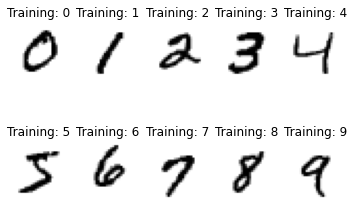

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_train == i)[0][0]
    plt.imshow(x_train[index,:,:],cmap=plt.cm.gray_r)
    plt.title('Training: %i' % y_train[index])
plt.show()

For further processing using keras functions, MNIST data must stacked in a 4D tensor with shape (samples, rows, cols, channels). In our case, channels=1 since we are working with greyscale images. As in lab session 3, pixel intensities need to rescaled between 0 and 1. Moreovre, labels can be described as one-hot vectors using the to_categorical() keras function.

In [4]:
img_rows, img_cols = 28, 28
num_classes = 10
# build 4D tensors
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# data normalization
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
# convert class vectors to binary class matrices
z_train = tf.keras.utils.to_categorical(y_train, num_classes)
z_test = tf.keras.utils.to_categorical(y_test, num_classes)

## II. Building a convolutional neural network with keras

The sequential Keras model is a linear stack of layers. You can create a sequential model by passing a list of layer instances to the constructor. Among the layer instances, you can use:
  - convolutional layer using [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)
  - max-pooling layer using [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
  - Regularization layer using [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)
  - regular densely-connected layer using [Dense](https://keras.io/api/layers/core_layers/dense/) 

In the previous notebook we have already explained what is Dropout and why it is used. Here we are going to consider additional layers:

#### Convolutional layers

**How does it work?**  CNN apply a matched filter to an input to create a feature map that summarizes the presence of detected features in the input. These filters can be handcrafted, such as line detectors, but the innovation of convolutional neural networks is to learn the filters during training in the context of a specific prediction problem. The result represent a filtering of the input (here a two-dimensional array of output values) which is called a _feature map_.
Once a feature map is created, we can pass each value in the feature map through a nonlinearity, such as a ReLU (see previous notebook), much like we do for the outputs of a fully connected layer.

**Why?** Matched filters are powerful detection methods in signal or image processing. Here the weights of the filter are learned during the training of the network. Specifically, training under stochastic gradient descent, the network is forced to learn to extract features from the image that minimize the loss for the specific task the network is being trained to solve, e.g. extract features that are the most useful for classifying images as dogs or cats.

#### Max pooling layers

**How does it work?** Pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality. Max pooling is done by applying a max filter to (usually) non-overlapping subregions of the initial representation.

**Why?**
This is done to in part to help over-fitting by providing an abstracted form of the representation which provides basic translation invariance to the internal representation.
Moreover  it reduces the computational cost by reducing the number of parameters to learn.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
# remove deprecated warning for tensorflow 2.0
import logging
logging.getLogger('tensorflow').disabled = True

Once keras modules have been imported, we can simply add layers using the `add()` method (see https://keras.io/api/models/sequential/#add-method)

In addition, the model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape. Conversely to the MLP example, here we don't flatten the image. We want to preserve the spatial structure in order to apply the 2D convolutional layer:

In [6]:
input_shape = (img_rows, img_cols, 1)

#### 1) Create a convolutional neural network following the architecture given below:
 - convolutional layer using 32 3x3 filters with stride 1 and "ReLU" activation
 - convolutional layer using 64 3x3 filters with stride 1 and "ReLU" activation
 - max pooling with vertical, horizontal downscale of 2
 - [flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/) to flatten the input array
 - dense layer with 128 units
 - dense layer with "num_classes=10" units

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Before training a model, you need to configure the learning process, which is done through the compile() method. It receives three arguments:

 - an optimizer: this could be the string identifier of an existing optimizer (such as rmsprop or adagrad), or an instance of the Optimizer class.
 - A loss function: this is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as categorical_crossentropy or mse), or an objective function.
 - A list of metrics to evaluate results. A metric could be the string identifier of an existing metric or a custom metric function.

### Define the loss, the optimizer and the metrics

See the previous notebook on MLP for some explanations on the categorical cross-entropy loss function, or on the stochastic gradient descent optimizers 

In [8]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
              metrics=['accuracy'])

### Describe input/output sizes of each layer. 

You can confirm your analysis by using model.summary()

In [9]:
from tensorflow.keras.utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
______________________________________________

Keras models are trained on Numpy arrays of input data and labels. For training a model, we can use the `fit()` function (see https://keras.io/api/models/model_training_apis/#fit-method).

We specify now the parameters to run the training using a batch size of 128 and 12 epochs. Test data will be used as validatation data.

In [10]:
batch_size = 128
epochs = 12
hist = model.fit(x_train, z_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_data=(x_test, z_test))

Epoch 1/12
469/469 [==============================] - 15s 33ms/step - loss: 0.1971 - accuracy: 0.9389 - val_loss: 0.0517 - val_accuracy: 0.9835
Epoch 2/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0455 - accuracy: 0.9862 - val_loss: 0.0363 - val_accuracy: 0.9877
Epoch 3/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0354 - val_accuracy: 0.9879
Epoch 4/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.0293 - val_accuracy: 0.9898
Epoch 5/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.0292 - val_accuracy: 0.9904
Epoch 6/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0280 - val_accuracy: 0.9916
Epoch 7/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0313 - val_accuracy:

## III. Evaluation

The `model.fit()` method returns an History callback, which has a history attribute containing the lists of successive losses and other metrics.

### Display the loss and the accuracy across training 

------------------------------
Displaying losses...


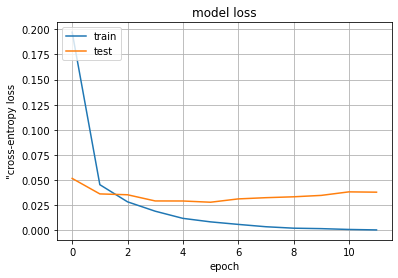

In [11]:
print('-'*30+'\n'+'Displaying losses...')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('"cross-entropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid('on')
plt.show()

------------------------------
Displaying accuracy...


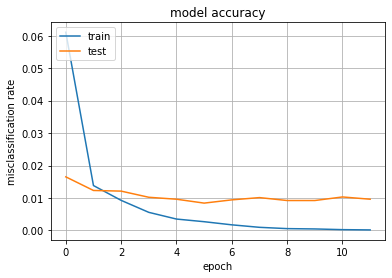

In [12]:
print('-'*30+'\n'+'Displaying accuracy...')
plt.plot(1.-np.asarray(hist.history['accuracy']))
plt.plot(1.-np.asarray(hist.history['val_accuracy']))
plt.title('model accuracy')
plt.ylabel('misclassification rate')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid('on')
plt.show()

### Evaluate the global test loss and accuracy 

This can be done using the `evaluate()` method on the model (see https://keras.io/api/models/model_training_apis/#evaluate-method).

In [13]:
score = model.evaluate(x_test, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])
print('Test accuracy:', score[1])


Test cross-entropy loss: 0.03801519423723221
Test misclassification rate: 0.00959998369216919
Test accuracy: 0.9904000163078308


### Visualize some wrongly predicted data

predicted probabilities for first test sample [7.4117215e-16 2.9472795e-16 3.0233708e-16 1.7677600e-12 2.0303294e-16
 2.6655068e-19 1.6616050e-26 1.0000000e+00 4.4544160e-16 7.9936746e-13]
predicted label for first test sample 7
10 first wrong prediction indexes [ 18 211 321 340 445 582 619 659 674 882]


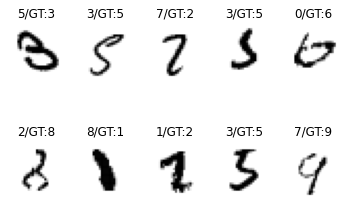

In [14]:
res = model.predict(x_test, batch_size=batch_size)
print('predicted probabilities for first test sample',res[0])
y_pred = np.argmax(res,axis=1)
print('predicted label for first test sample',y_pred[0])
indexes = np.where(y_test-y_pred != 0)[0][:10] 
print('10 first wrong prediction indexes',indexes)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_test[indexes[i],:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i/GT:%i' %(y_pred[indexes[i]],y_test[indexes[i]]))
plt.show()

Up to now, we have learned how to quickly and easily build, train, and evaluate a convolutional neural network using Keras. The final test set accuracy on MNIST dataset is approximately 99% which is slightly better than the results obtained with MLP.

### IV. Robustness to noise

### Evaluate the network predictions on noisy data with two different noise factors

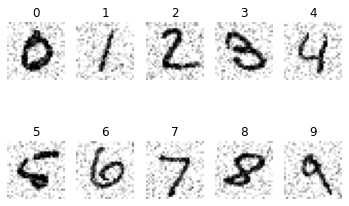

Test cross-entropy loss: 0.060207996517419815
Test misclassification rate: 0.014800012111663818


In [15]:
noise_factor = 0.2 # sigma
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_test == i)[0][0]
    plt.imshow(x_test_noisy[index,:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i' % y_test[index])
plt.show()
score = model.evaluate(x_test_noisy, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])


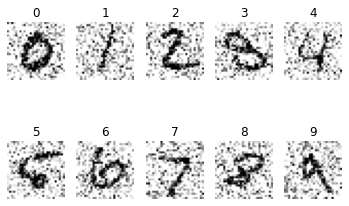

Test cross-entropy loss: 0.7262199521064758
Test misclassification rate: 0.156000018119812


In [16]:
noise_factor = 0.4 # sigma
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    index = np.where(y_test == i)[0][0]
    plt.imshow(x_test_noisy[index,:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i' % y_test[index])
plt.show()
score = model.evaluate(x_test_noisy, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])



With strong noise, the accuracy decreases from more than 99% to less than 80% since training samples are not enough representative. Let us train the model directly on noisy data samples to see the performance.

### Train and evaluate the same CNN architecture on very noisy data

In [17]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

model_noise = Sequential()
model_noise.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_noise.add(Conv2D(64, (3, 3), activation='relu'))
model_noise.add(MaxPooling2D(pool_size=(2, 2)))
model_noise.add(Flatten())
model_noise.add(Dense(128, activation='relu'))
model_noise.add(Dense(num_classes, activation='softmax'))

model_noise.compile(loss=tf.keras.losses.categorical_crossentropy, 
                    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0), 
                    metrics=['accuracy'])

model_noise.fit(x_train_noisy, z_train, batch_size=batch_size, epochs=epochs, verbose=1,
                validation_data=(x_test_noisy, z_test))

score = model_noise.evaluate(x_test_noisy, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 15s 32ms/step - loss: 0.3210 - accuracy: 0.8993 - val_loss: 0.1121 - val_accuracy: 0.9656
Epoch 2/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0913 - accuracy: 0.9714 - val_loss: 0.0844 - val_accuracy: 0.9729
Epoch 3/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.0771 - val_accuracy: 0.9756
Epoch 4/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0375 - accuracy: 0.9887 - val_loss: 0.0777 - val_accuracy: 0.9750
Epoch 5/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.0756 - val_accuracy: 0.9788
Epoch 6/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0894 - val_accuracy: 0.9780
Epoch 7/12
469/469 [==============================] - 15s 32ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0979 - val_accuracy:

### What is the expected result when using Dropout layers? 

Evaluate the network without Dropout layers and conclude based on global test accuracy 

Remember that Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. See previous notebook for supplementary explanations

In [18]:
model_noise2 = Sequential()
model_noise2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_noise2.add(Conv2D(64, (3, 3), activation='relu'))
model_noise2.add(MaxPooling2D(pool_size=(2, 2)))
model_noise2.add(Dropout(0.25))
model_noise2.add(Flatten())
model_noise2.add(Dense(128, activation='relu'))
model_noise2.add(Dropout(0.5))
model_noise2.add(Dense(num_classes, activation='softmax'))

model_noise2.compile(loss=tf.keras.losses.categorical_crossentropy, 
                     optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0), metrics=['accuracy'])

model_noise2.fit(x_train_noisy, z_train, batch_size=batch_size, epochs=epochs, verbose=1,
                validation_data=(x_test_noisy, z_test))

score = model_noise2.evaluate(x_test_noisy, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 16s 34ms/step - loss: 0.4108 - accuracy: 0.8688 - val_loss: 0.1135 - val_accuracy: 0.9639
Epoch 2/12
469/469 [==============================] - 16s 34ms/step - loss: 0.1549 - accuracy: 0.9535 - val_loss: 0.0927 - val_accuracy: 0.9707
Epoch 3/12
469/469 [==============================] - 16s 34ms/step - loss: 0.1200 - accuracy: 0.9625 - val_loss: 0.0793 - val_accuracy: 0.9724
Epoch 4/12
469/469 [==============================] - 16s 34ms/step - loss: 0.1026 - accuracy: 0.9692 - val_loss: 0.0813 - val_accuracy: 0.9743
Epoch 5/12
469/469 [==============================] - 16s 34ms/step - loss: 0.0876 - accuracy: 0.9727 - val_loss: 0.0713 - val_accuracy: 0.9764
Epoch 6/12
469/469 [==============================] - 16s 34ms/step - loss: 0.0786 - accuracy: 0.9762 - val_loss: 0.0718 - val_accuracy: 0.9766
Epoch 7/12
469/469 [==============================] - 16s 34ms/step - loss: 0.0721 - accuracy: 0.9772 - val_loss: 0.0669 - val_accuracy:

For this "small" convolutional network, performance is actually nearly identical with and without dropout. Here, around 98%. Dropout is often very effective at reducing overfitting, but it is most useful when training very large neural networks.

## V. Towards deeper networks

In this last part, we come back to the original dataset, i.e. without additional noise.

### Implement a deeper convolutional neural network 
We are going to add two convolutional  layers and one max pooling layer before the first Dropout. What is the performance gain?

In [19]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
               metrics=['accuracy'])

#plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model2.png')

model2.fit(x_train, z_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x_test, z_test))

score = model2.evaluate(x_test, z_test, verbose=0)
print('Test cross-entropy loss:', score[0])
print('Test misclassification rate:', 1-score[1])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 18s 38ms/step - loss: 0.2998 - accuracy: 0.9049 - val_loss: 0.0508 - val_accuracy: 0.9835
Epoch 2/12
469/469 [==============================] - 18s 38ms/step - loss: 0.0901 - accuracy: 0.9739 - val_loss: 0.0344 - val_accuracy: 0.9887
Epoch 3/12
469/469 [==============================] - 18s 39ms/step - loss: 0.0645 - accuracy: 0.9802 - val_loss: 0.0293 - val_accuracy: 0.9901
Epoch 4/12
469/469 [==============================] - 18s 38ms/step - loss: 0.0517 - accuracy: 0.9852 - val_loss: 0.0221 - val_accuracy: 0.9929
Epoch 5/12
469/469 [==============================] - 18s 39ms/step - loss: 0.0442 - accuracy: 0.9868 - val_loss: 0.0233 - val_accuracy: 0.9927
Epoch 6/12
469/469 [==============================] - 18s 38ms/step - loss: 0.0370 - accuracy: 0.9885 - val_loss: 0.0215 - val_accuracy: 0.9933
Epoch 7/12
469/469 [==============================] - 18s 39ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.0181 - val_accuracy:

This slightly more deeper network reaches around 99,5% in terms of accuracy (instead of around 99% previously)

### Analyze the errors and the confusion matrix:

predicted probabilities for first test sample [7.4117215e-16 2.9472795e-16 3.0233708e-16 1.7677600e-12 2.0303294e-16
 2.6655068e-19 1.6616050e-26 1.0000000e+00 4.4544160e-16 7.9936746e-13]
predicted label for first test sample 7
10 first wrong prediction indexes [ 321  445  449  646  947  965 1014 1039 1232 1247]


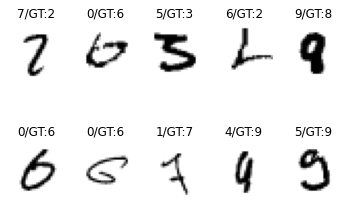

In [20]:
z_pred = model2.predict(x_test)
print('predicted probabilities for first test sample',res[0])
y_pred = np.argmax(z_pred, axis=1)
print('predicted label for first test sample',y_pred[0])
indexes = np.where(y_test-y_pred != 0)[0][:10] 
print('10 first wrong prediction indexes',indexes)
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_test[indexes[i],:,:,0], cmap=plt.cm.gray_r)
    plt.title('%i/GT:%i' %(y_pred[indexes[i]],y_test[indexes[i]]))
plt.show()

Normalized confusion matrix


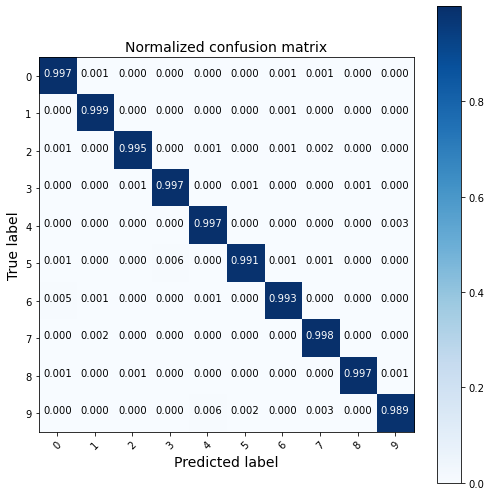

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

z_pred = model2.predict(x_test)
y_pred = np.argmax(z_pred,axis=1)

class_names= ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

To conclude, an overview of results obtained with different methodologies can be found here: https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.